# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [32]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [33]:
df = pd.read_csv('bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          731 non-null    int64  
 1   yr              731 non-null    int64  
 2   mnth            731 non-null    int64  
 3   holiday         731 non-null    int64  
 4   weekday         731 non-null    int64  
 5   workingday      731 non-null    int64  
 6   weathersit      731 non-null    int64  
 7   temp            731 non-null    float64
 8   atemp           731 non-null    float64
 9   hum             731 non-null    float64
 10  windspeed(mph)  731 non-null    float64
 11  windspeed(ms)   731 non-null    float64
 12  cnt             731 non-null    int64  
dtypes: float64(5), int64(8)
memory usage: 74.4 KB


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

In [35]:
# Отримання ознак (features)
data_features = df.columns[:-1]

# Отримання цільової змінної (target)
data_target = df.columns[-1]

# Виведення отриманих даних
print(f"df_features = {data_features}")
print(f"df_target = {data_target}")

df_features = Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)',
       'windspeed(ms)'],
      dtype='object')
df_target = cnt


Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

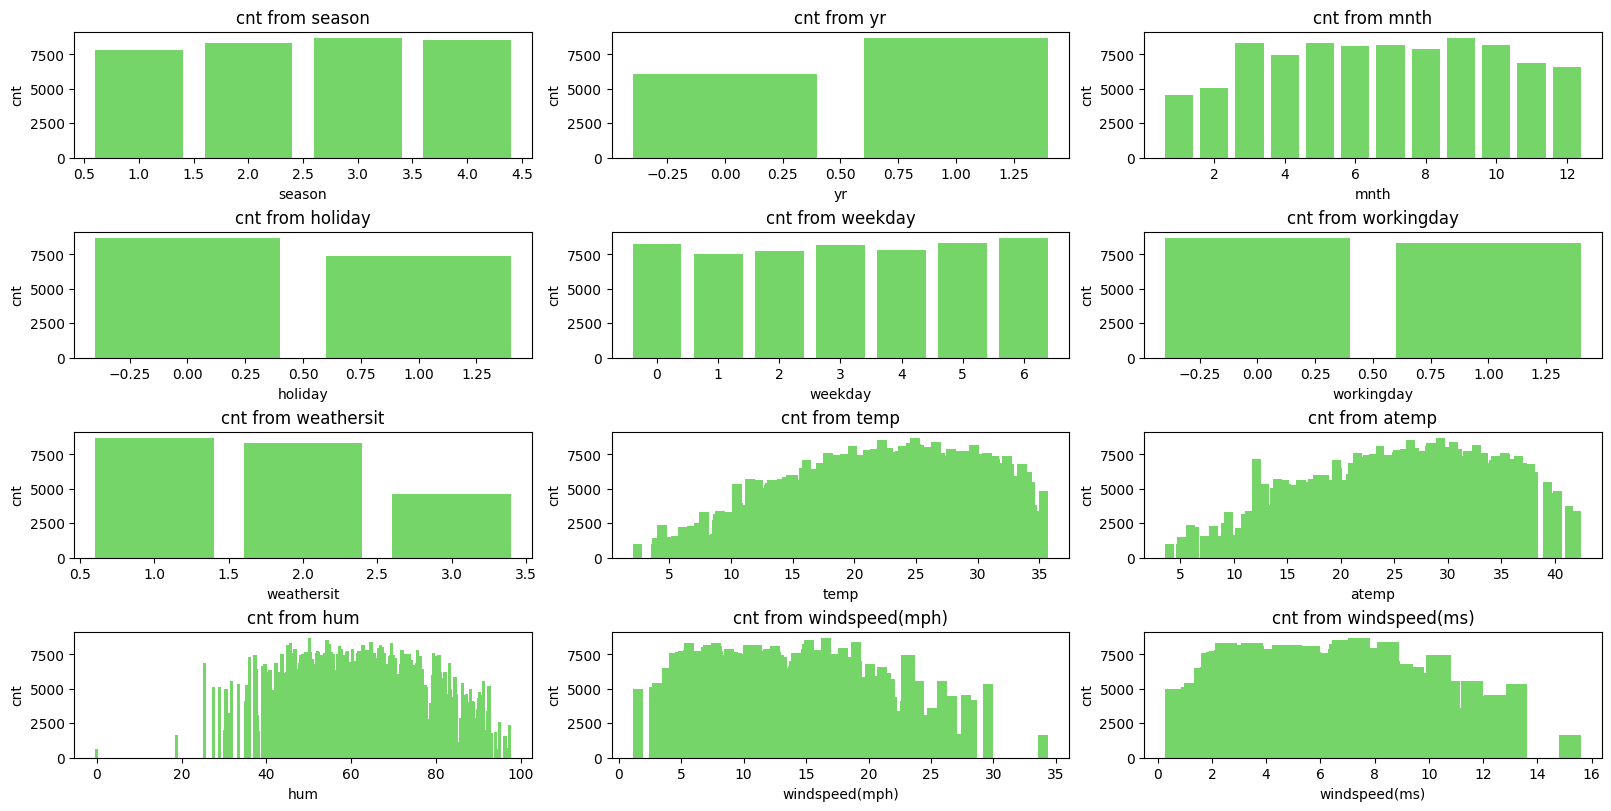

In [36]:
def plot_series(ax, df, xlabel, ylabel):
    xs = df[xlabel]
    ys = df[ylabel]
    ax.set_title(f'{ylabel} from {xlabel}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.bar(xs, ys, color='#75d568')
    
cols = 3
fig, axs = plt.subplots(len(data_features) // cols, cols, figsize=(16, 8), constrained_layout=True)
for ax, feature in zip(axs.flat, data_features):
    plot_series(ax, df, feature, data_target)
plt.show()

In [37]:
# Розрахунок матриці кореляції
correlation_matrix = df.corr()

# Виведення кореляції ознак з cnt
correlation_with_cnt = correlation_matrix['cnt'].sort_values(ascending=False)

print(f"Матриця залежностей = {correlation_with_cnt}")

Матриця залежностей = cnt               1.000000
atemp             0.631066
temp              0.627494
yr                0.566710
season            0.406100
mnth              0.279977
weekday           0.067443
workingday        0.061156
holiday          -0.068348
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
weathersit       -0.297391
Name: cnt, dtype: float64


__Запитання:__ <br>
`1. Яким є характер залежності кількості прокатів від місяця?` <br>
Відповідь: <br>
* Весняні та літні місяці (березень - серпень) мають вищу середню кількість прокатів в порівнянні з іншими місяцями.
* Зниження кількості прокатів спостерігається у вересні і жовтні, а також у грудні і січні.
* Можна помітити, що восени (вересень-листопад) кількість прокатів поступово зменшується.
* Таким чином, згідно з наданими даними, можна сказати, що кількість прокатів має сезонну залежність, з піковими значеннями у весняні та літні місяці і зменшенням у весняні і зимові місяці.

`2. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.` <br>
Відповідь: temp та atemp <br>
Ці дві ознаки мають найбільшу позитивну кореляцію з кількістю прокатів (cnt), що означає, що зі збільшенням цих ознак кількість прокатів також збільшується.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [38]:
correlations = df.iloc[:, :-1].corrwith(df['cnt'])
print(correlations)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

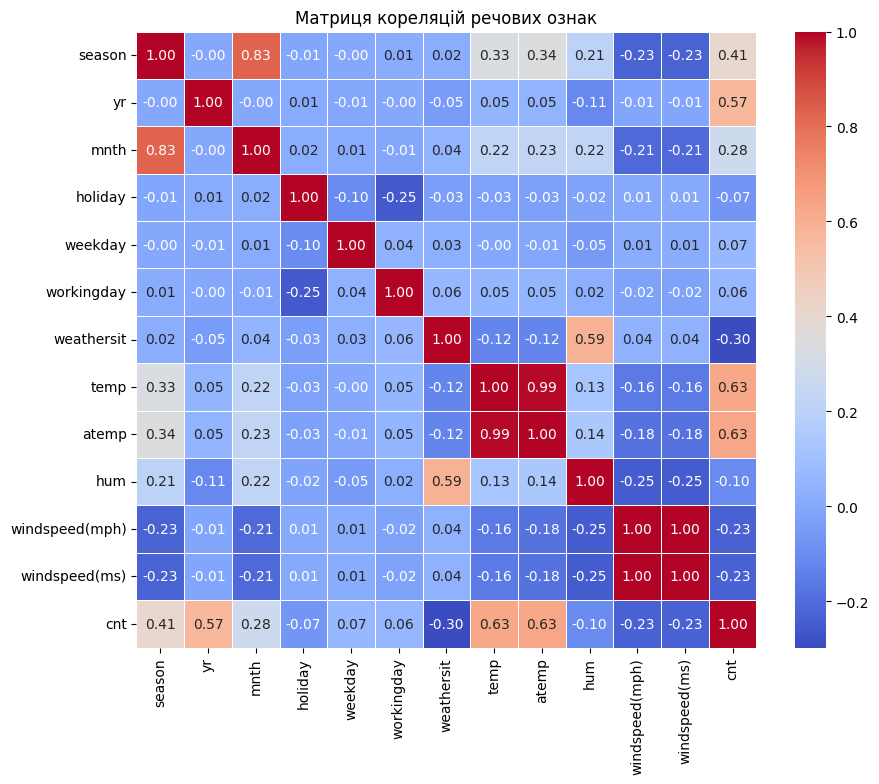

In [39]:
# Вибірка речових ознак
numeric_features = df.select_dtypes(include=['float64', 'int64'])

# Розрахунок кореляцій
numeric_correlations = numeric_features.corr()

# Відображення теплової карти
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матриця кореляцій речових ознак')
plt.show()

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

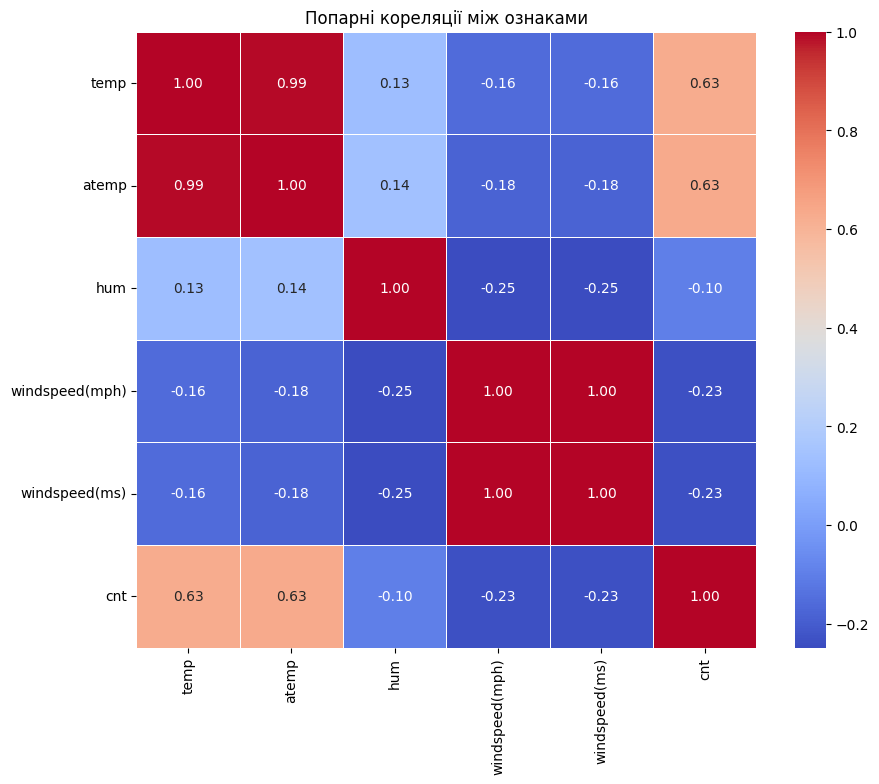

In [40]:
# Вибірка потрібних ознак для розрахунку кореляцій
features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
correlations = df[features].corr()

# Створення теплової карти
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Попарні кореляції між ознаками')
plt.show()

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [41]:
print("Середні значення ознак:")
mean_values = df.mean()
mean_values

Середні значення ознак:


season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [42]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [43]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

In [44]:
print(f"{X.max()=}") 
print(f"{X.min()=}") 
print(f"{X[0].max()=}") 
print(f"{X[0].min()=}")

X.max()=5.814595756329395
X.min()=-4.411486147280981
X[0].max()=1.5886601861579452
X[0].min()=-0.7260481545646825


Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [45]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [46]:
regressor = LinearRegression()

regressor.fit(X, y)

weights = regressor.coef_

for feature, weight in zip(df.columns[:-1], weights):
    print(f"{feature}: {weight}")

season: 570.8638501320808
yr: 1021.968374035042
mnth: -141.30042714888475
holiday: -86.7589678764022
weekday: 137.2260243674752
workingday: 56.39207450989123
weathersit: -330.22859154239825
temp: 367.45187644001305
atemp: 585.5777455406493
hum: -145.61314651687744
windspeed(mph): 12456475364833.373
windspeed(ms): -12456475365031.836


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

In [47]:
from sklearn.linear_model import Ridge, Lasso

In [48]:
ridge_regressor = Ridge()
ridge_regressor.fit(X, y)

lasso_regressor = Lasso()
lasso_regressor.fit(X, y)

Lasso()

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [49]:
print("Ваги моделі Lasso:")
for feature, weight in zip(df.columns[:-1], lasso_regressor.coef_):
    print(f"{feature}:  {weight:.4f}")

Ваги моделі Lasso:
season:  560.2416
yr:  1019.4635
mnth:  -128.7306
holiday:  -86.1528
weekday:  137.3479
workingday:  55.2124
weathersit:  -332.3699
temp:  376.3632
atemp:  576.5308
hum:  -144.1292
windspeed(mph):  -197.1397
windspeed(ms):  -0.0000


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [50]:
print("Ваги моделі Ridge:")
for feature, weight in zip(df.columns[:-1], ridge_regressor.coef_):
    print(f"{feature}: {weight:.4f}")

Ваги моделі Ridge:
season: 563.0646
yr: 1018.9484
mnth: -131.8733
holiday: -86.7461
weekday: 138.0051
workingday: 55.9031
weathersit: -332.3498
temp: 386.4579
atemp: 566.3470
hum: -145.0713
windspeed(mph): -99.2594
windspeed(ms): -99.2594


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [51]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)
    
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print(f"Форма масиву coefs_lasso: {coefs_lasso.shape}")
print(f"Форма масиву coefs_ridge: {coefs_ridge.shape}")

Форма масиву coefs_lasso: (10, 12)
Форма масиву coefs_ridge: (10, 12)


Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

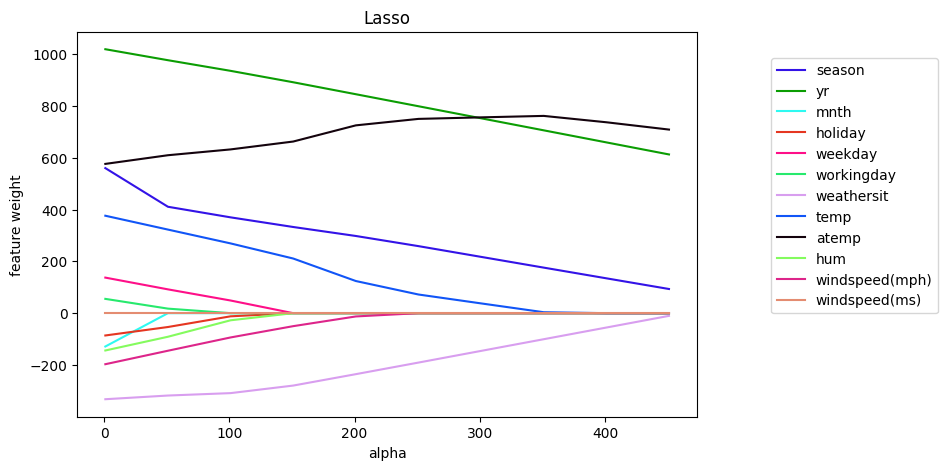

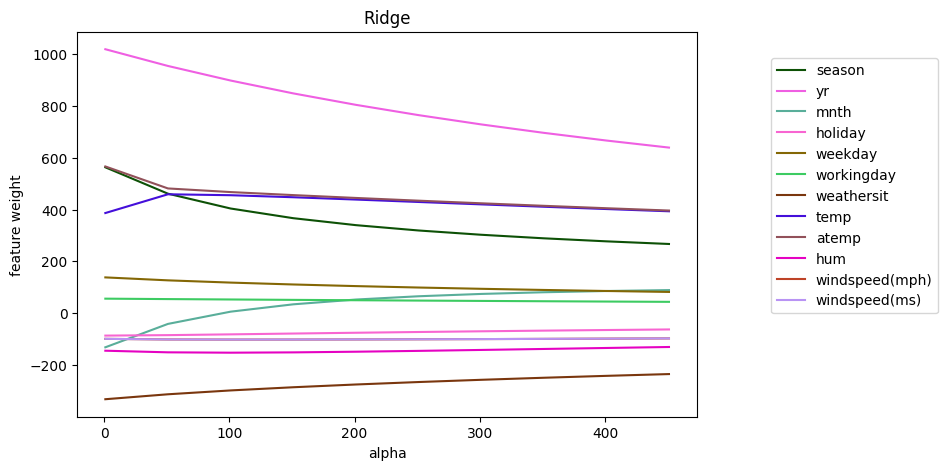

In [52]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha? <br>
    Відповідь: Lasso
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається. <br>
    Відповідь: Якщо alpha зробити дуже великим, то ваги признаків з Lasso регуляризацією будуть близькі до нуля
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$. <br>
    Відповідь: Так, можна стверджувати, що Lasso виключає один з признаків windspeed при будь-якому значенні alpha > 0. На графіках видно, що вага при признаку windspeed(ms) стає нульовою при досить малих значеннях alpha (приблизно alpha > 50)
1. Який із регуляризаторів підійде для відбору неінформативних ознак? <br>
    Відповідь: Lasso регуляризація підходить для відбору неінформативних признаків, оскільки вона обнуляє ваги признаків при певних значеннях alpha

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [53]:
def create_plot(data, title, xlabel, ylabel, figsize=None, min=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)
    
    x = [e[0] for e in data]
    y = [e[1] for e in data]
    plt.plot(x, y)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if min is not None:
        plt.text(min[0], min[1], f"min: ({int(min[0])}, {int(min[1])})", ha="center")
    else:
        min_idx = np.argmin(y)
        min_y = np.min(y)
        min_x = x[min_idx]
        plt.text(min_x, min_y, f"min: ({int(min_x)}, {int(min_y)})", ha="center")
    
    plt.grid()
    plt.show()

Shape of regressor.coef_: (12,)
Shape of regressor.alphas: (20,)
Shape of regressor.mse_path_: (20, 3)
Alphas used: [96 91 86 81 76 71 66 61 56 51 46 41 36 31 26 21 16 11  6  1]


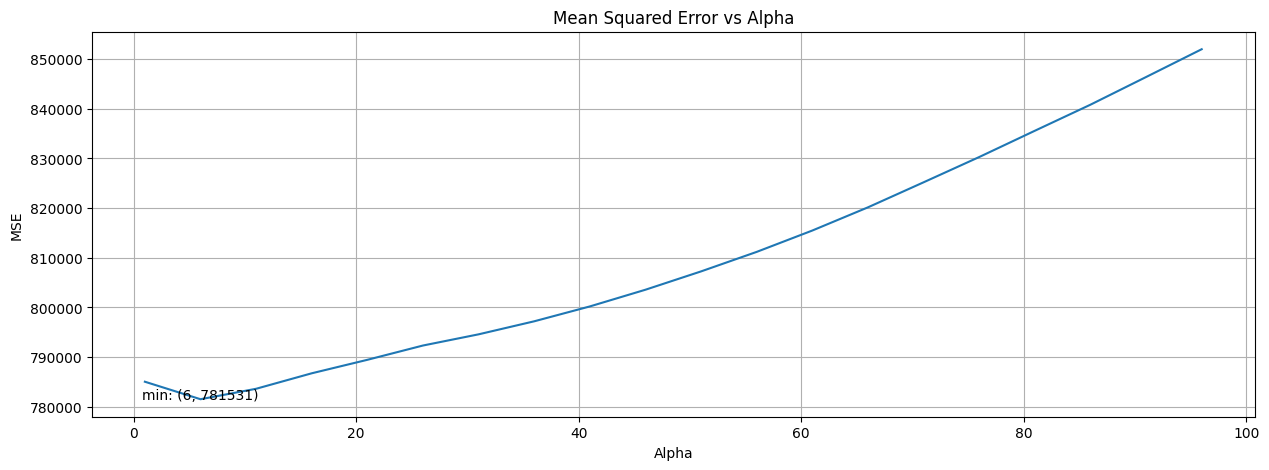

In [54]:
from sklearn.linear_model import LassoCV

SEED = 42
alphas = np.arange(1, 100, 5)
regressor = LassoCV(random_state=SEED, alphas=alphas, cv=3)
regressor.fit(X, y)

print(f"Shape of regressor.coef_: {regressor.coef_.shape}")
print(f"Shape of regressor.alphas: {regressor.alphas_.shape}")
print(f"Shape of regressor.mse_path_: {regressor.mse_path_.shape}")
print(f"Alphas used: {regressor.alphas_}")

mse_values = np.mean(regressor.mse_path_, axis=1)
data = np.vstack((regressor.alphas_, mse_values))

create_plot(data.T, "Mean Squared Error vs Alpha", "Alpha", "MSE")

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


In [55]:
print("Alphas with minimum MSE:")
print(f"Shape of mse_path_: {regressor.mse_path_.shape}")

min_values = np.min(regressor.mse_path_, axis=0)
min_idx = np.argmin(regressor.mse_path_, axis=0)

alphas = []
for i, idx in enumerate(min_idx):
    mse = min_values[i]
    alpha = regressor.alphas_[idx]
    alphas.append(alpha)
    print(f"Split {i+1}: Alpha = {alpha}, MSE = {mse}")

Alphas with minimum MSE:
Shape of mse_path_: (20, 3)
Split 1: Alpha = 6, MSE = 733725.760405224
Split 2: Alpha = 1, MSE = 799433.1673691698
Split 3: Alpha = 51, MSE = 796979.8955193625


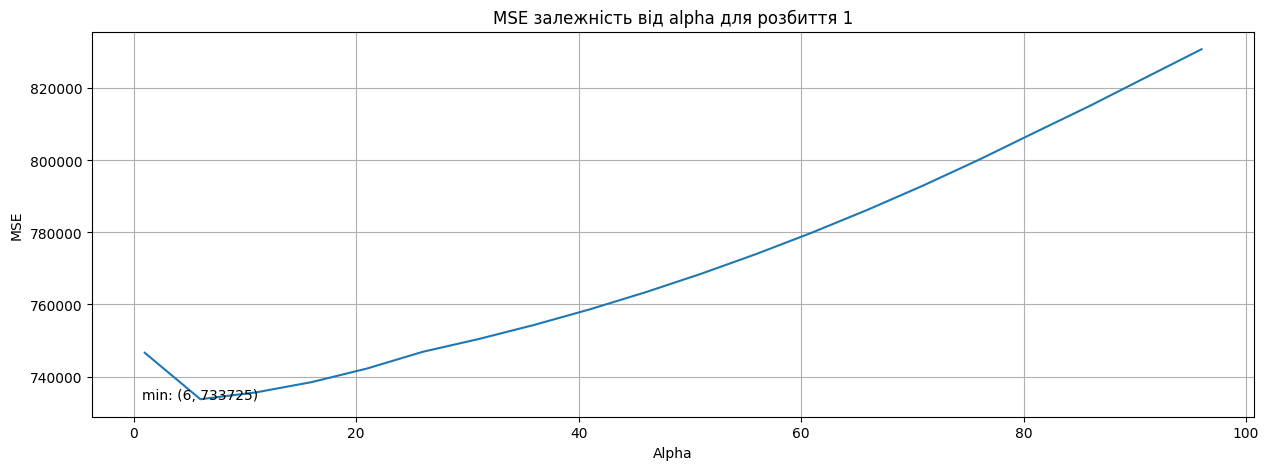

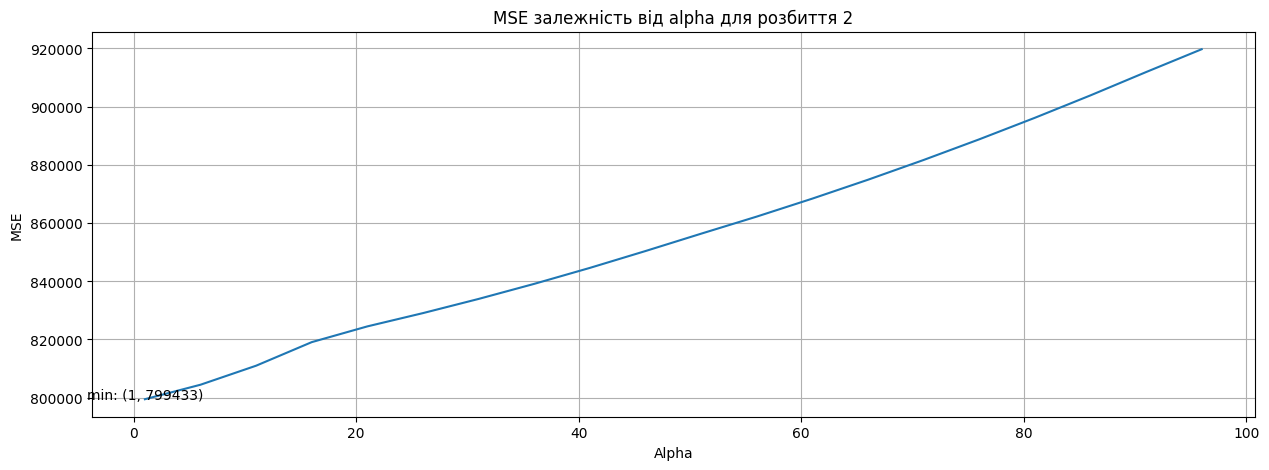

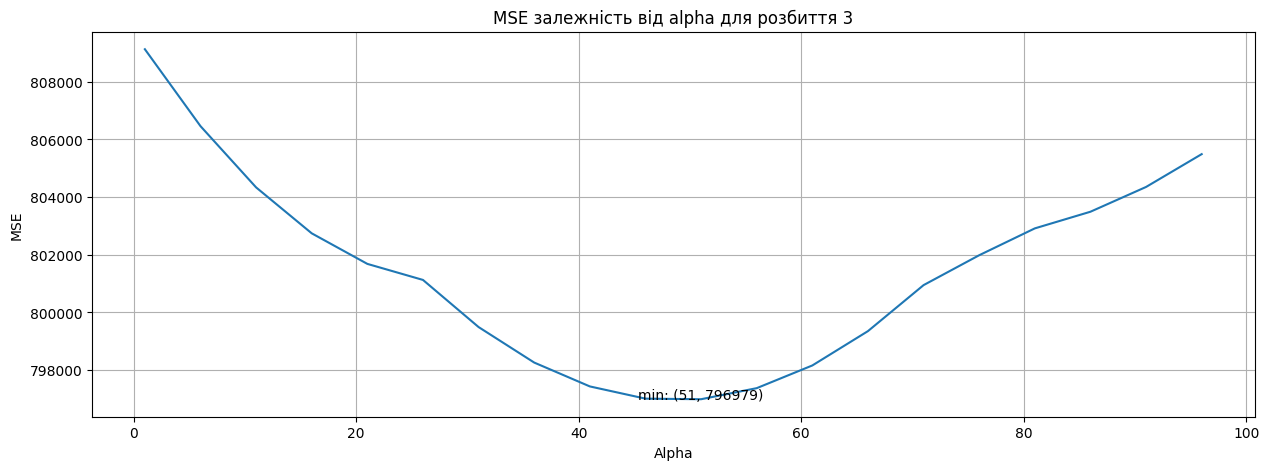

In [56]:
for col in range(regressor.mse_path_.shape[1]):
    data = np.vstack((regressor.alphas_, regressor.mse_path_[:, col]))
    create_plot(data.T, f"MSE залежність від alpha для розбиття {col+1}", "Alpha", "MSE", min=(alphas[col], min_values[col]))

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [59]:
# Отримання коефіцієнтів
coefficients = list(zip(df.columns[:-1], regressor.coef_))

# Сортування коефіцієнтів за спаданням
sorted_coefficients = sorted(coefficients, key=lambda x: x[1], reverse=True)

# Вибір 4 ознак з найбільшими позитивними коефіцієнтами
top_positive_features = sorted_coefficients[:4]

# Виведення вибраних ознак
print("4 ознаки з найбільшими позитивними коефіцієнтами:")
for feature, coefficient in top_positive_features:
    print(f"{feature}: {coefficient.round(4)}")

4 ознаки з найбільшими позитивними коефіцієнтами:
yr: 1015.0602
atemp: 581.3969
season: 532.019
temp: 370.6799


#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [61]:
data_coef = pd.DataFrame(regressor.coef_,index=df.columns[:-1], columns=["Weight"]) 

top_negative_features = data_coef[data_coef['Weight'] < 0].abs().sort_values(by='Weight', ascending=False).head(3).round(4)

# Виводимо ці ознаки та їх відповідні коефіцієнти
print(top_negative_features)

                  Weight
weathersit      330.5599
windspeed(mph)  191.7714
hum             140.0074


weathersit: Ця ознака вказує на погодні умови.

windspeed(mph): Ця ознака вказує на швидкість вітру у милях за годину.

hum: Ця ознака представляє вологість.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [62]:
# Вибір ознак з коефіцієнтами, близькими до нуля
near_zero_coef = data_coef[np.abs(data_coef['Weight']) < 1e-3]
print(near_zero_coef)

                     Weight
windspeed(ms) -2.685533e-08


### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.